In [53]:
%cd /Users/mahdi/workspace/ct2d-seg-pytorch
import sys, importlib
sys.path.insert(0, "src")
import merge_masks_test; importlib.reload(merge_masks)


/Users/mahdi/workspace/ct2d-seg-pytorch


<module 'merge_masks' from '/Users/mahdi/workspace/ct2d-seg-pytorch/src/merge_masks.py'>

In [54]:
# Test parsing only (unit-test style)
args = parse_args([
    "--images","data/raw/images",
    "--labels_root","data/raw/masks",
    "--out","data/processed/masks_indexed",
    "--classes","cort_bone","trab_bone","hbm","imat","muscle","mat","sub_fat",
    "--skip_empty"
])
args

Namespace(images='data/raw/images', labels_root='data/raw/masks', out='data/processed/masks_indexed', classes=['cort_bone', 'trab_bone', 'hbm', 'imat', 'muscle', 'mat', 'sub_fat'], mask_prefix='', mask_suffix='', skip_empty=True)

In [55]:
run_merge(
    images="data/raw/dicoms_n",
    labels_root="data/raw/masks",
    out="data/processed/masks_indexed",
    classes=["cort_bone","trab_bone","hbm","imat","muscle","mat","sub_fat"],
    skip_empty=True
)

Class order (last wins): ['cort_bone', 'trab_bone', 'hbm', 'imat', 'muscle', 'mat', 'sub_fat']
Saved 300 masks to data/processed/masks_indexed. Skipped 0.
Missing per class (file not found for that stem):
  cort_bone: 0
  trab_bone: 0
  hbm: 0
  imat: 0
  muscle: 0
  mat: 0
  sub_fat: 0


In [50]:
from pathlib import Path
import numpy as np, cv2, random

MASK_DIR = Path("data/processed/masks_indexed")   # change if needed
IMG_DIR  = Path("data/raw/dicoms_n")                # for overlay later (DICOMs)

mask_paths = sorted(list(MASK_DIR.glob("*.png"))) + sorted(list(MASK_DIR.glob("*.PNG")))
print(f"Found {len(mask_paths)} masks")
assert mask_paths, "No masks found — check MASK_DIR"

# peek one
m0 = cv2.imread(str(mask_paths[0]), cv2.IMREAD_GRAYSCALE)
print("shape:", m0.shape, "dtype:", m0.dtype, "min/max:", int(m0.min()), int(m0.max()))
uniq, cnt = np.unique(m0, return_counts=True)
print("unique values & counts:", dict(zip(uniq.tolist(), cnt.tolist())))


Found 300 masks
shape: (512, 512) dtype: uint8 min/max: 0 7
unique values & counts: {0: 221486, 1: 4846, 2: 1406, 3: 1744, 4: 318, 5: 20268, 6: 8293, 7: 3783}


In [51]:
import numpy as np

max_label_seen = 0
counts = None
total_pixels = 0

for p in mask_paths:
    m = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    if m is None:
        print("WARN: failed to read", p)
        continue
    max_label_seen = max(max_label_seen, int(m.max()))
    bins = np.bincount(m.ravel(), minlength=256)  # up to 255 if needed
    counts = bins if counts is None else (counts + bins)
    total_pixels += m.size

labels_present = np.flatnonzero(counts) if counts is not None else []
print("Labels present in dataset:", labels_present.tolist())
print("Max label:", max_label_seen)

# summarize first 10 labels (0..7 for your case)
limit = max(9, max_label_seen)
summary = {i: int(counts[i]) for i in range(limit+1)}
print("Counts (0..{}):".format(limit), summary)

if total_pixels:
    print("Non-background coverage (% of pixels that are >0):",
          round(100.0 * (total_pixels - counts[0]) / total_pixels, 3), "%")


Labels present in dataset: [0, 1, 2, 3, 4, 5, 6, 7]
Max label: 7
Counts (0..9): {0: 62149091, 1: 1646825, 2: 584473, 3: 1078119, 4: 304106, 5: 6810272, 6: 4962175, 7: 1108139, 8: 0, 9: 0}
Non-background coverage (% of pixels that are >0): 20.973 %


In [43]:
bad = []
for p in mask_paths:
    m = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    u = np.unique(m)
    if (u.min() < 0) or (u.max() > 7):
        bad.append((p.name, u.tolist()))
print("Masks with unexpected values:", bad[:20])
print("Total bad:", len(bad))


Masks with unexpected values: []
Total bad: 0


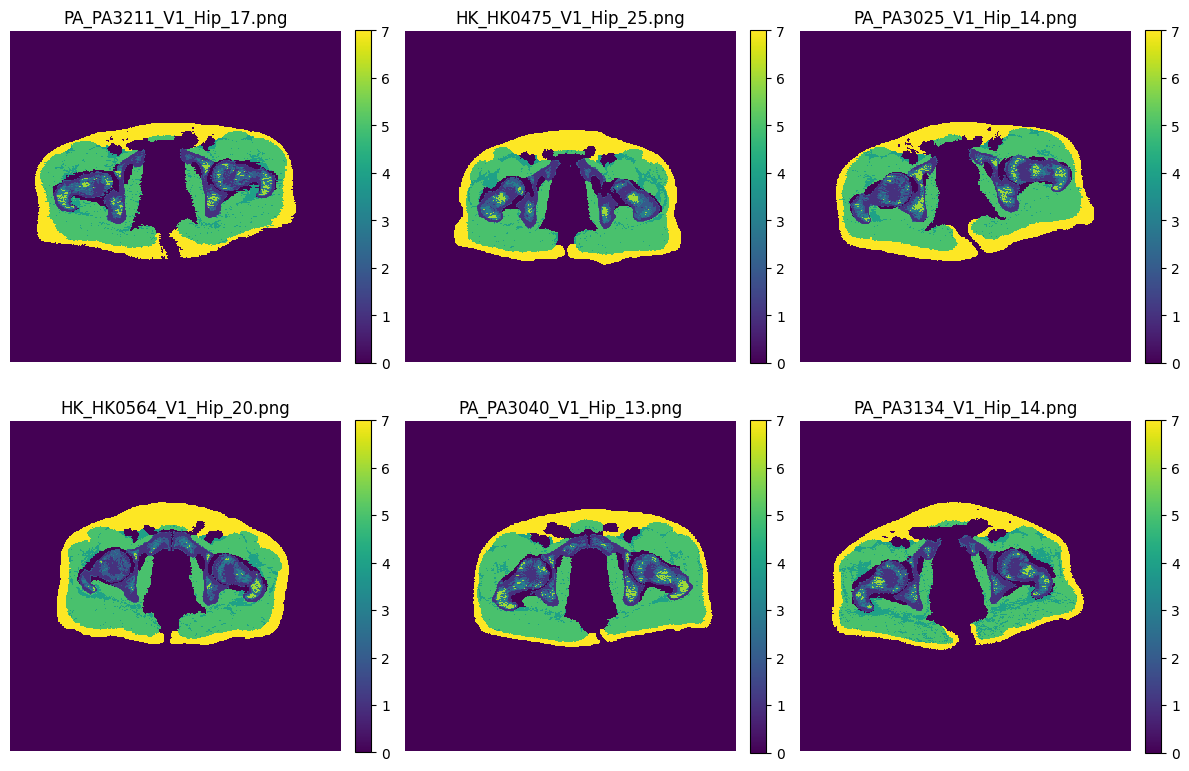

In [56]:
import matplotlib.pyplot as plt
from math import ceil

k = 6  # how many to show
show = random.sample(mask_paths, min(k, len(mask_paths)))

cols = 3
rows = ceil(len(show)/cols)
plt.figure(figsize=(cols*4, rows*4))

for i, p in enumerate(show, 1):
    m = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    ax = plt.subplot(rows, cols, i)
    im = ax.imshow(m, interpolation="nearest")
    ax.set_title(p.name)
    ax.axis("off")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


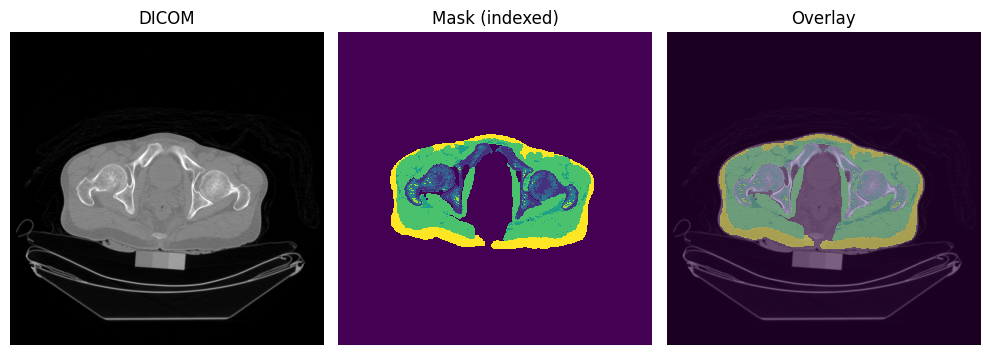

In [57]:
import pydicom, matplotlib.pyplot as plt

def read_dicom_float01(path):
    d = pydicom.dcmread(str(path))
    img = d.pixel_array.astype(np.float32)
    slope = float(getattr(d, "RescaleSlope", 1.0))
    inter = float(getattr(d, "RescaleIntercept", 0.0))
    img = img * slope + inter
    img = np.clip(img, -1000, 1000)
    img = (img + 1000.0) / 2000.0
    return img

# pick one case that exists as both DICOM and mask
case = None
for p in mask_paths:
    stem = p.stem
    dcm = IMG_DIR / f"{stem}.dcm"
    if dcm.exists():
        case = (dcm, p)
        break
assert case, "Couldn't find a matching DICOM for any mask. Check IMG_DIR."

dcm_path, mask_path = case
img = read_dicom_float01(dcm_path)
m   = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

# resize mask if needed for display (training code will also resize safely)
if img.shape != m.shape:
    m_vis = cv2.resize(m, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
else:
    m_vis = m

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(img, cmap="gray"); plt.title("DICOM"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(m_vis, interpolation="nearest"); plt.title("Mask (indexed)"); plt.axis("off")
plt.subplot(1,3,3); 
plt.imshow(img, cmap="gray"); 
plt.imshow(m_vis, alpha=0.4, interpolation="nearest"); 
plt.title("Overlay"); plt.axis("off")
plt.tight_layout(); plt.show()


In [49]:
p = random.choice(mask_paths)
m = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
print("Inspecting:", p.name, "shape:", m.shape)
coords = [(m.shape[0]//2, m.shape[1]//2), (10,10), (50,50)]
for (r,c) in coords:
    print(f"m[{r},{c}] =", int(m[r,c]))


Inspecting: PA_PA3320_V1_Hip_17.png shape: (512, 512)
m[256,256] = 0
m[10,10] = 0
m[50,50] = 0


In [ ]:
\
  --images data/raw/dicoms_n \
  --labels_root data/raw/masks \
  --out data/processed/masks_indexed \
  --classes cort_bone trab_bone hbm imat muscle mat sub_fat \
  --skip_empty
